In [34]:
import pandas as pd     # Se carga la Libreria de pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity


In [35]:
# Se carga el dataset games desde el archivo csv
df_games= pd.read_csv('DataSet_tranformados/games.csv',delimiter = ',',encoding = "utf-8")

In [36]:
# Se carga el dataset reviews desde el archivo csv
df_reviews= pd.read_csv('DataSet_tranformados/reviews.csv',delimiter = ',',encoding = "utf-8")

In [37]:
# Se carga el dataset items desde el archivo csv
df_items= pd.read_parquet('DataSet_tranformados/items.parquet')

###########################################################################################################

Se grafican los juegos por genero para ver cuantos juegos hay genero

C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_15088\2740675413.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_games,x='genres', palette='winter')


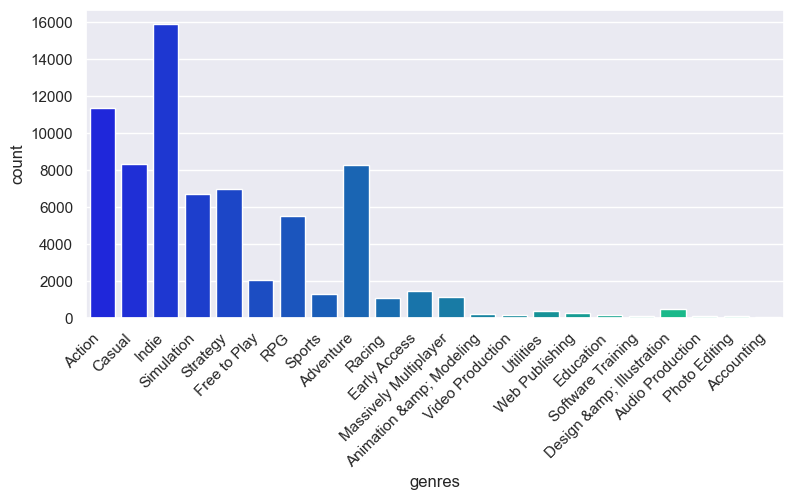

In [38]:
plt.figure(figsize= (9,4))
sns.countplot(data=df_games,x='genres', palette='winter')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

In [39]:
# se crea una lista de generos que se utilizaran
lista_generos= ['Action','Indie','RPG','Simulation','Adventure','Free to Play','Strategy','Massively Multiplayer','Casual','Sports','Racing']
df_games = df_games.loc[df_games['genres'].isin(lista_generos)]

In [40]:
df_merge= pd.merge(df_games, df_reviews, on='game_id', how= 'inner')

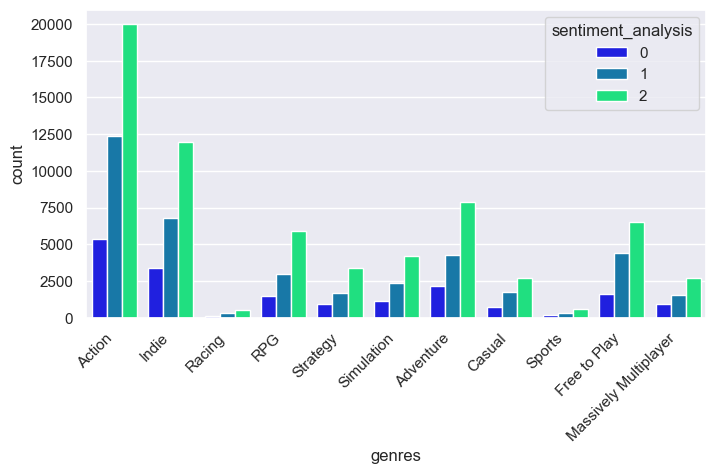

In [41]:
plt.figure(figsize= (8,4))
sns.countplot(data=df_merge,x='genres',hue='sentiment_analysis', palette='winter') 
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

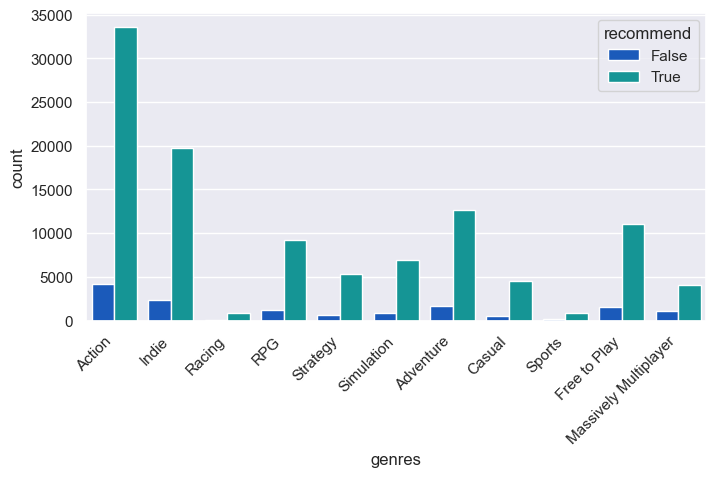

In [42]:
plt.figure(figsize= (8,4))
sns.countplot(data=df_merge,x='genres',hue='recommend', palette='winter') 
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()

En base a es estos graficos se puede ver que los generos menos recomendados y menos evaluaciones son "Racing" y Sports y los mas recomendados y jugados con "Action", "Indie" y "Aventura"

In [43]:

df_game_dummies = pd.get_dummies(df_games, columns=['genres'], prefix='', prefix_sep='')        # se generan los dummies de de los generos
df_games_genre_dummy = df_game_dummies.groupby('game_id', as_index=False).sum()                 # se agrupa por id de juego y se unen los dummies de generos

df_review_dummies = pd.get_dummies(df_reviews, columns=['sentiment_analysis'], prefix='', prefix_sep='')    # se generan los dummies del analisis de sentimientos
df_review_sent_dummy = df_review_dummies.groupby('game_id', as_index=False).sum()       # se agrupa por id de juego y se suman los analisis de sentimintos

df_union_games_review= pd.merge(df_games_genre_dummy, df_review_sent_dummy, on='game_id', how= 'inner')     # se hace una union de los juegos con los reviews         
# se agrupa por id de juego y se unen los dummies de analisis de sentimintos
df_items_Xgameid= df_items.groupby('game_id', as_index=False)['playtime_forever'].sum()

# se hace una union del df donde se guardo la union de los juegos y reviews con el df de items
df_union_games_revs_items= pd.merge(df_union_games_review, df_items_Xgameid, on='game_id', how= 'inner')
# Se filtra del df por los juegos con mas de 10000 para mejorar el rendimiento de la api en render
df_union_games_revs_items = df_union_games_revs_items[df_union_games_revs_items['playtime_forever'] > 10000]
df_union_games_revs_items = df_union_games_revs_items.reset_index(drop=True)        # se resetean los indices 


In [44]:
df_games_recomend= df_union_games_revs_items[['game_id','game_name']]       #se genera un df con las columnas id y el nombre del juego

In [45]:
df_union_games_revs_items= df_union_games_revs_items.drop(['game_id','game_name','release_year','user_id','year',], axis=1) # Eliminar columnas innecesarias

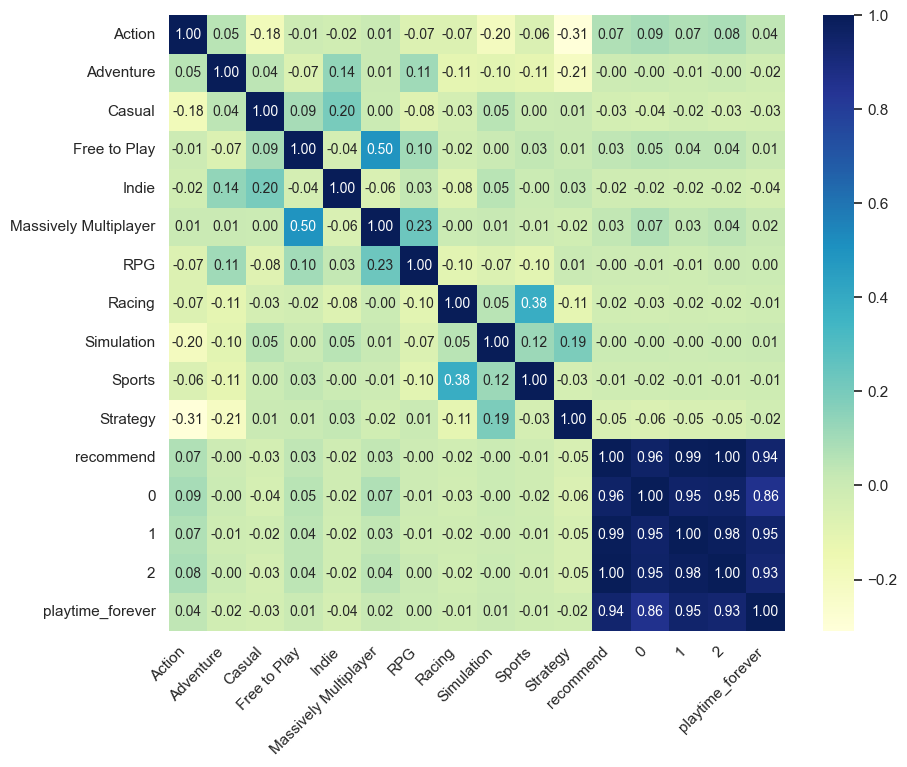

In [46]:
#df_union_games_revs_items.head(10)
fig = plt.figure(figsize= (10,8))
sns.heatmap(df_union_games_revs_items.corr(), annot=True, cmap="YlGnBu", annot_kws={"size": 10  }, cbar=True, square=True, fmt='.2f')
plt.xticks(rotation=45, horizontalalignment='right')
plt.yticks(rotation=0)
plt.show()

Las correlaciones mas fuertes estan en el analisis de sentimientos, los recomendados y las horas jugadas

In [47]:
escalar= StandardScaler()       # se instancia un objeto con la clase para hacer el standar scaler
df_escalado = escalar.fit_transform(df_union_games_revs_items)  # se le aplica la escalacion a los valores del df
similitudes= cosine_similarity(df_escalado)     # Se genera una matriz con la similitud del coseno de los juegos

In [48]:
similitudes.shape

(2158, 2158)

In [58]:
def recomendacion_juego(id_game: int):
    result= {}          # se inicializa una variable tipo diccionario
    lista_juegos= []    # se inicializa una variable tipo lista
    indice = df_games_recomend.loc[df_games_recomend['game_id'] == id_game].index   # se busca si existe el id del juego y se guarda el indice
    if indice.empty:    # si el indice esta vacio duevuelve un mensaje de error
        result= {"Error": 'JUEGO NO ENCONTRADO'}
    else:
        indice= indice[0]   # se tranforma el indice a numerico        
        # se ordenan las distancias de coseno en la posicion del indice del juego en la matriz de similitudes 
        distancias= sorted(list(enumerate(similitudes[indice])), reverse= True, key=lambda x:x[1])
        nombre_juego= df_games_recomend.iloc[indice]['game_name']       # Toma el nombre del juego ingresado
        for i, item in enumerate(distancias[1:6]):        # se itera sobre los primeros 5  items de la lista omitiendo el 1ro
            lista_juegos.append({str(i+1)+'. ':df_games_recomend.iloc[item[0]]['game_name']})       # se guarda en una lista los primeros 5 juegos
        result = {'Juegos remomendados para':nombre_juego, 'Lista de similares:':lista_juegos }     # se muestra el resultado con la lista en formato json
    return result

In [60]:
recomendacion_juego(50)

{'Juegos Remomendados para': 'Half-Life: Opposing Force',
 'Lista de Similares:': [{'1. ': 'STAR WARS™ Jedi Knight II - Jedi Outcast™'},
  {'2. ': 'Defence Alliance 2'},
  {'3. ': 'Unreal Tournament 3 Black'},
  {'4. ': 'Crysis Warhead®'},
  {'5. ': 'Red Orchestra: Ostfront 41-45'}]}

In [268]:
np.save('DataSet_tranformados/modelo.npy', similitudes)     # se guarda la matriz de similitudes en un archivo para ser usado en el main de la API

In [ ]:
df_games_recomend.to_csv('DataSet_tranformados/games_modelo_ML.csv', index=False)   # se exporta el df para se usado en la funcion de la API

In [56]:
df_games_recomend.head(10)

,game_id,game_name
0,10,Counter-Strike
1,20,Team Fortress Classic
2,30,Day of Defeat
3,40,Deathmatch Classic
4,50,Half-Life: Opposing Force
5,60,Ricochet
6,70,Half-Life
7,80,Counter-Strike: Condition Zero
8,130,Half-Life: Blue Shift
9,220,Half-Life 2


####################################################################################################